In [1]:
import numpy as np
import matplotlib.pyplot as plt

import central_system as cs
import analyze_control as ac
import read_load as rl

# 検討ケース

In [2]:
case = {
    'region': 6,
    'a_mr': 29.81,
    'a_or': 51.34,
    'a_a': 120.08,
    'r_env': 2.95556,
    'insulation': 'h11',
    'solar_gain': 'middle',
    'default_heat_source_spec': True,
    'supply_air_rtd_h': 1800.0,
    'supply_air_rtd_c': 1800.0,
    'is_duct_insulated': True,
    'vav_system': False,
    'cap_rtd_h': 12000.0,
    'cap_rtd_c': 12000.0,
}

1日グラフを描画する日を指定する。

In [3]:
hday = '2/1'
cday = '9/1'

# 物性値

## 空気の密度

空気の密度 $\rho$ は 1.2 kg/m<sup>3</sup> とする。

In [4]:
rho = cs.get_air_density()
rho

1.2

## 空気の比熱

空気の比熱 $c$ は1006.0 J/kgK とする。

In [5]:
c = cs.get_specific_heat()
c

1006.0

## ダクトの線熱損失係数

ダクトの潜熱損失係数 $\psi$ は 0.49 W/mK とする。

In [6]:
psi = cs.get_duct_linear_heat_loss_coefficient()
psi

0.49

# 暖冷房負荷

室 $i$ の暖房負荷 $L_{H,d,t,i}$ 、顕熱冷房負荷 $L_{CS,d,t,i}$ 、潜熱冷房負荷 $L_{CL,d,t,i}$ は、主たる居室・その他の居室の床面積、床面積の合計、断熱性能、日射熱取得性能に応じて決定される。

In [7]:
l_h, l_cs, l_cl = cs.get_load(region=case['region'], insulation=case['insulation'], solar_gain=case['solar_gain'],
                  a_mr=case['a_mr'], a_or=case['a_or'], a_a=case['a_a'], r_env=case['r_env'])

今回使用する居室（room number 1 - 5）の負荷およびその合計、非居室を含めた全部屋の負荷（旧評価方法で使用。新評価方法では非居室の負荷は使用しない。）を描画する。

In [8]:
def make_list(load_data):

    return [(load_data[0], 'room 1'),
            (load_data[1], 'room 2'),
            (load_data[2], 'room 3'),
            (load_data[3], 'room 4'),
            (load_data[4], 'room 5'),
            (np.sum(load_data[0:5], axis=0), 'room 1-5'),
            (np.sum(load_data, axis=0), 'room 1-12')]

## 年間

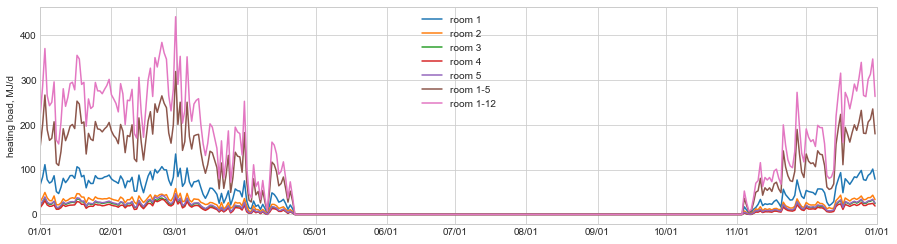

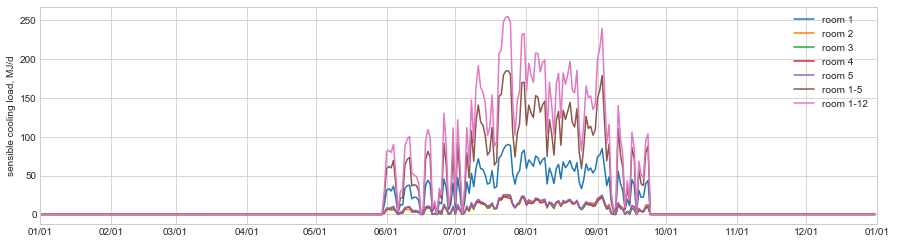

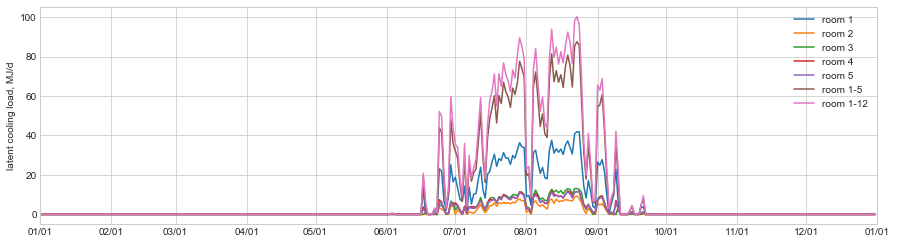

In [9]:
ac.draw_graph('heating load, MJ/d', make_list(l_h), 'itg')

ac.draw_graph('sensible cooling load, MJ/d', make_list(l_cs), 'itg')

ac.draw_graph('latent cooling load, MJ/d', make_list(l_cl), 'itg')

## 1日単位

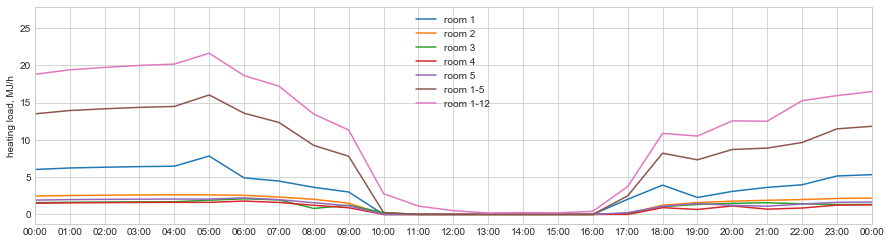

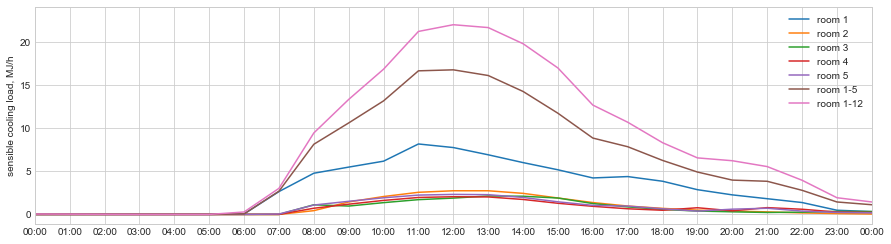

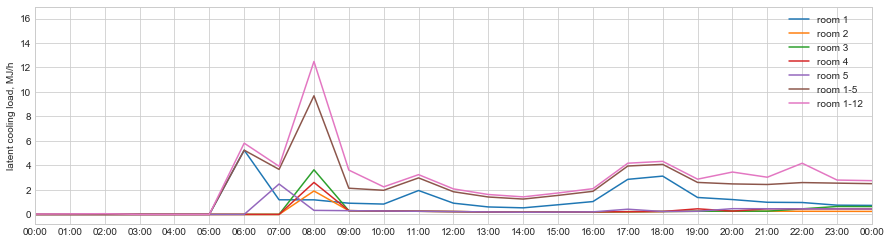

In [10]:
ac.draw_graph(y_title='heating load, MJ/h', ys=make_list(l_h), op='raw', display_date=hday)
ac.draw_graph(y_title='sensible cooling load, MJ/h', ys=make_list(l_cs), op='raw', display_date=cday)
ac.draw_graph(y_title='latent cooling load, MJ/h', ys=make_list(l_cl), op='raw', display_date=cday)

In [11]:
l_duct_in_r, l_duct_ex_r, l_duct_in_total = cs.get_standard_house_duct_length()

In [12]:
def draw_duct_length(room_number):
    
    xs = np.arange(120)

    def get_duct_length_each_room(room_number):
        return [cs.get_duct_length(l_duct_r_i=l_duct_in_total, a_a=x)[room_number] for x in xs]
    
    plt.style.use('seaborn-whitegrid')

    fig = plt.figure()

    ax = fig.subplots()
    
    ax.plot(xs, get_duct_length_each_room(0), label='room 1')
    ax.plot(xs, get_duct_length_each_room(1), label='room 2')
    ax.plot(xs, get_duct_length_each_room(2), label='room 3')
    ax.plot(xs, get_duct_length_each_room(3), label='room 4')
    ax.plot(xs, get_duct_length_each_room(4), label='room 5')
    
    plt.legend()
    plt.show()

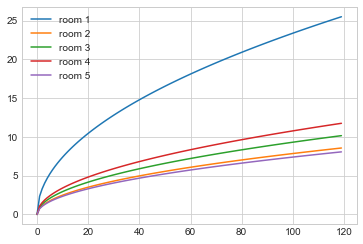

In [13]:
draw_duct_length(0)